In [1]:
import numpy as np
import pandas as pd
import glob
import os, sys
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
VERSION = 4
RANDOM_SEED = 7

In [ ]:
# !pip install tensorflow

## Load data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive/')
!ls

Mounted at /content/gdrive
 code  'Colab Notebooks'   data_extracted_features   dataset   dataset_split   models


### Load Data - downsampled

In [3]:
# df_joint_train_org   = pd.read_csv(f'./data_extracted_features/cache_all_features_train_V{VERSION}.csv')
# df_joint_train_org   = df_joint_train_org.drop(columns=['GNE_max_gne','GNE_mean_gne','GNE_stddev_gne','GNE_sum_gne'])

# df_joint_test_org = pd.read_csv(f'./data_extracted_features/cache_all_features_test_V{VERSION}.csv').drop(
#     columns=['GNE_max_gne','GNE_mean_gne','GNE_stddev_gne','GNE_sum_gne'])

# print("shape of train set: ", df_joint_train_org.shape)
# print("shape of test  set: ", df_joint_test_org.shape)


# df_joint_train  = pd.read_csv(f'./data_extracted_features/cache_train_V4_resampled_2500.csv')
df_joint_test = pd.read_csv(f'./features/cache_test_V4_resampled_250.csv')

# print("shape of train set: ", df_joint_train.shape)
print("shape of test  set: ", df_joint_test.shape)

df_joint_train_aug  = pd.read_csv(f'./features/cache_train_V4_augmented.csv')
feature_column_names = [i for i in df_joint_train_aug.columns \
                        if i not in ['file_path','renamed_file_path','split','sentiment_value','emotional_category']]

print("shape of train set: ", df_joint_train_aug.shape)
df_joint_train_aug.groupby('sentiment_value')['file_path'].count()

shape of test  set:  (680, 1546)
shape of train set:  (24885, 1546)


sentiment_value
-1    7999
 0    8560
 1    8326
Name: file_path, dtype: int64

### best guess feature combinations

In [4]:
# generate selected features
def generate_selected_features_by_type(feature_column_names,input,stats,number=1):
    selected_result = []
    for name in feature_column_names:
        if input+"_"+stats in name:
            selected_result.append(name)
    if number < len(selected_result):
        selected_result = selected_result[:number]
    return selected_result

# example to take mfcc 20 mean & std; mel32; zcr all 5 stats features
feature_MFCC20_mean  = generate_selected_features_by_type(feature_column_names,"mfcc","mean",20)
feature_MFCC20_std   = generate_selected_features_by_type(feature_column_names,"mfcc","std",20)
feature_mel32_median = generate_selected_features_by_type(feature_column_names,"mel32","median",32)
feature_mel32_std    = generate_selected_features_by_type(feature_column_names,"mel32","std",32)
feature_zcr_stats    = generate_selected_features_by_type(feature_column_names,"zcr","",5)
feature_rms_stats    = generate_selected_features_by_type(feature_column_names,"rms","",5)
selected_spect = ['Spectrum_band_energy_difference','Spectrum_band_density_difference','Spectrum_center_of_gravity_spectrum','Spectrum_skewness_spectrum','Spectrum_kurtosis_spectrum', 'Spectrum_stddev_spectrum','Spectrum_band_density', 'Spectrum_band_energy']
selected_formant = ['Formant_f1_mean','Formant_f1_median','Formant_f3_mean','Formant_fitch_vtl','Formant_mff','Formant_formant_dispersion']
selected_pitch = ['Pitch_pitch_slope_without_octave_jumps', 'Pitch_q3_pitch','Pitch_stddev_pitch', 'Pitch_mean_absolute_pitch_slope','Pitch_mean_pitch', 'Pitch_max_pitch', 'Pitch_q1_pitch', 'Pitch_min_pitch']
selected_intensity = ['Intensity_max_intensity', 'Intensity_q3_intensity','Intensity_median_intensity', 'Intensity_mean_intensity', 'Intensity_stddev_intensity','Intensity_relative_max_intensity_time']
selected_HNR = ['HNR_stddev_hnr', 'HNR_mean_hnr','HNR_relative_min_hnr_time','HNR_max_hnr']
selected_prosody = selected_intensity + selected_pitch # + ['Local Jitter','Local Shimmer']
selected_feature_names = feature_MFCC20_mean + feature_MFCC20_std + feature_mel32_median + feature_mel32_std + \
                         feature_rms_stats + selected_intensity + selected_pitch + selected_spect

In [5]:
# default use augmented training set and balanced test set
X_train = df_joint_train_aug[selected_feature_names]
y_train_s = df_joint_train_aug['sentiment_value']
y_train_e = df_joint_train_aug['emotional_category']

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_e_num = label_encoder.fit_transform(y_train_e)

X_test = df_joint_test[selected_feature_names]
y_test_s = df_joint_test['sentiment_value']
y_test_e = df_joint_test['emotional_category']

y_test_e_num = label_encoder.fit_transform(y_test_e)

In [7]:
len(selected_intensity), len(selected_pitch), len(selected_spect)

(6, 8, 8)

In [6]:
X_train.shape, X_test.shape

((24885, 131), (680, 131))

## Models - conventional ML

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier,HistGradientBoostingClassifier
from lightgbm import LGBMClassifier

# Common adjustable parameters
common_params = {
    'RandomForest': {'n_estimators': 100, 'criterion':'gini', 'max_depth': None,
                     'min_samples_split':100, 'bootstrap':True, 'n_jobs':3, 'random_state': RANDOM_SEED},
    'SVM': {'kernel': 'rbf', 'C': 1.0, 'probability': True},
    'KNN': {'n_neighbors': 5},
    'GradientBoosting': {'loss': 'log_loss', 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1.0,
                         'criterion': 'friedman_mse', 'min_samples_split': 2, 'max_depth': 3},
    'GradientBoostingFast': {'loss': 'log_loss', 'learning_rate': 0.1, 'max_iter': 100},
    'AdaBoost': {'n_estimators': 50, 'learning_rate': 1.0},
    'LightGBM': {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1.0,
                 'min_child_samples': 20, 'max_depth': -1}
}

# Models with common adjustable parameters
dtree   = DecisionTreeClassifier()
rforest = RandomForestClassifier(**common_params['RandomForest'])
svm     = SVC(**common_params['SVM'])
knn     = KNeighborsClassifier(**common_params['KNN'])
gboost  = GradientBoostingClassifier(**common_params['GradientBoosting'])
gb_fast = HistGradientBoostingClassifier(**common_params['GradientBoostingFast'])
adaBoost= AdaBoostClassifier(**common_params['AdaBoost'])
lightgbm=LGBMClassifier(**common_params['LightGBM'])

### experiment classifier

In [11]:
import pickle

def exp_clf_with_feature_selected(clf_model, X_train, X_test, y_train, y_test,verbose=True):
    start = time.time()

    clf_model.fit(X_train, y_train)
    predictions = clf_model.predict(X_test.values)

    # Calculate metrics
    report = classification_report(y_test, predictions, output_dict=True)
    metrics = {
        'accuracy': report['accuracy'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1-score': report['macro avg']['f1-score']
    }
    for class_name in report.keys():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics[class_name+'_precision'] = report[class_name]['precision']
            metrics[class_name+'_recall'] = report[class_name]['recall'],
            metrics[class_name+'_f1-score'] = report[class_name]['f1-score']

    feature_columns = list(X_train.columns)
    num_classes = y_train.nunique()
    class_names = list(y_train.unique())

    model_filename = f"./models/{clf_model.__class__.__name__}_model"
    model_filename += f"_{num_classes}cls_{len(feature_columns)}feat_{round(report['accuracy']*100)}acc.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(clf_model, file)

    results = {**metrics,
        'num_classes': num_classes,
        'class_names': class_names,
        'model_filename': model_filename,
        'feature_columns': feature_columns,
    }

    if verbose:
        print(f"Model Name: {clf_model.__class__.__name__};\nTrain set shape {X_train.shape}, num of class {num_classes}")
        print(classification_report(y_test, predictions))
        print(confusion_matrix(y_test, predictions))
        probabilities = clf_model.predict_proba(X_test.values)
        print('Probabilities distribution:\n', pd.DataFrame(probabilities, columns=clf_model.classes_).describe())
    print(f"Model: {clf_model.__class__.__name__};Time taken: {round(time.time()-start, 3)} seconds.\n")

    return results, clf_model


### Sentiment 3-class Classifier Sample code

In [ ]:
# change model as the first parameter in the function
result, m_trained = exp_clf_with_feature_selected(rforest, X_train, X_test, y_train_s, y_test_s)

Model Name: RandomForestClassifier;
Train set shape (24885, 131), num of class 3
              precision    recall  f1-score   support

          -1       0.70      0.77      0.73       248
           0       0.68      0.86      0.76       183
           1       0.88      0.62      0.73       249

    accuracy                           0.74       680
   macro avg       0.75      0.75      0.74       680
weighted avg       0.76      0.74      0.74       680

[[191  41  16]
 [ 20 158   5]
 [ 61  33 155]]
Probabilities distribution:
                -1           0           1
count  680.000000  680.000000  680.000000
mean     0.398042    0.281497    0.320461
std      0.227307    0.264152    0.270539
min      0.008433    0.000200    0.004270
25%      0.258860    0.025624    0.111430
50%      0.369035    0.216568    0.230583
75%      0.543687    0.476297    0.424664
max      0.952376    0.982654    0.990326
Model: RandomForestClassifier;Time taken: 5.237 seconds.



### How to save experiment metrics result

In [ ]:
exp_results = []
for clf_model in [rforest, knn, gb_fast,adaBoost]:
    result, m_trained = exp_clf_with_feature_selected(clf_model, X_train, X_test, y_train_s, y_test_s,verbose=False)
    exp_results.append(result)
pd.DataFrame(exp_results)

In [ ]:
pd.DataFrame(exp_results).to_excel("exp_result.xlsx")

### Emotion 8-class

In [ ]:
comb_84 = feature_MFCC20_mean + feature_MFCC20_std + feature_zcr_stats + selected_HNR + selected_formant + \
            feature_rms_stats + selected_intensity + selected_pitch + selected_spect+\
            ['Local Jitter','Local Shimmer']
X_train = df_joint_train_aug[comb_84]
X_test = df_joint_test[comb_84]
exp_clf_with_feature_selected(rforest, X_train, X_test, y_train_e, y_test_e, verbose=False)

Model Name: RandomForestClassifier;
Train set shape (24885, 84), num of class 8
              precision    recall  f1-score   support

       Anger       0.74      0.65      0.69        62
    Calmness       0.39      1.00      0.56        16
     Disgust       0.72      0.21      0.33        62
        Fear       0.94      0.26      0.41        62
   Happiness       0.69      0.67      0.68       187
  Neutrality       0.59      0.88      0.71       167
     Sadness       0.56      0.52      0.54        62
    Surprise       0.87      0.85      0.86        62

    accuracy                           0.65       680
   macro avg       0.69      0.63      0.60       680
weighted avg       0.69      0.65      0.63       680

[[ 40   0   0   0  18   1   1   2]
 [  0  16   0   0   0   0   0   0]
 [  0   3  13   1  14  25   5   1]
 [  1   0   1  16  14  18   9   3]
 [ 13   7   4   0 125  35   2   1]
 [  0   8   0   0   4 147   8   0]
 [  0   5   0   0   2  22  32   1]
 [  0   2   0   0   5   

({'accuracy': 0.65,
  'precision': 0.6874315613239665,
  'recall': 0.6290699608201227,
  'f1-score': 0.5954085578190418,
  'Anger_precision': 0.7407407407407407,
  'Anger_recall': (0.6451612903225806,),
  'Anger_f1-score': 0.689655172413793,
  'Calmness_precision': 0.3902439024390244,
  'Calmness_recall': (1.0,),
  'Calmness_f1-score': 0.5614035087719299,
  'Disgust_precision': 0.7222222222222222,
  'Disgust_recall': (0.20967741935483872,),
  'Disgust_f1-score': 0.325,
  'Fear_precision': 0.9411764705882353,
  'Fear_recall': (0.25806451612903225,),
  'Fear_f1-score': 0.4050632911392405,
  'Happiness_precision': 0.6868131868131868,
  'Happiness_recall': (0.6684491978609626,),
  'Happiness_f1-score': 0.6775067750677507,
  'Neutrality_precision': 0.588,
  'Neutrality_recall': (0.8802395209580839,),
  'Neutrality_f1-score': 0.7050359712230216,
  'Sadness_precision': 0.5614035087719298,
  'Sadness_recall': (0.5161290322580645,),
  'Sadness_f1-score': 0.5378151260504201,
  'Surprise_precisio

### Threshold tuning

In [ ]:
# Calculate accuracy for the given threshold
def calc_acc_by_thres(probabilities, threshold, y_test):
    predictions_adj = []
    # Loop through each sample's probabilities
    for probs in probabilities:
        if probs[0] > threshold:
            pred_class = -1
        elif probs[1] > probs[2]:
            pred_class = 0
        else:
            pred_class = 1
        predictions_adj.append(pred_class)
    accuracy = np.mean(predictions_adj == y_test)
    precision, recall, f1score, _ = precision_recall_fscore_support(y_test_s, predictions_adj, average=None)
    return accuracy, min(f1score), np.var(f1score)

best_threshold = None
best_accuracy = 0.0
best_f1score = 0.0
# best_f1s_var = 10

# Define a range of threshold values to try
threshold_range = np.linspace(0.25, 0.75, 100)
for threshold in threshold_range:
    accuracy, min_f1_score, var_f1_score = calc_acc_by_thres(probabilities, threshold, y_test_s)
    # if accuracy > best_accuracy:
    #     best_accuracy = accuracy
    #     best_threshold = threshold
    if min_f1_score > best_f1score:
        best_f1score = min_f1_score
        best_threshold = threshold
        best_accuracy = accuracy
    # if var_f1_score < best_f1s_var:
    #     best_f1score = min_f1_score
    #     best_threshold = threshold
    #     best_accuracy = accuracy
    #     best_f1s_var = var_f1_score


print("Best Threshold:", best_threshold)
print("Best Accuracy:", best_accuracy)
print("Best min f1 score:", best_f1score)
# print("Best var f1 score:", best_f1s_var)

## CNN Model
data loading
and model structure


### data loading

In [7]:
# Convert x_train to float32
X_train_cnn = np.expand_dims(X_train, axis=2).astype(np.float32)
y_train_e_cnn = y_train_e_num.astype(np.float32)
X_test_cnn = np.expand_dims(X_test, axis=2).astype(np.float32)
y_test_e_cnn = y_test_e_num.astype(np.float32)
y_train_s_cnn = y_train_s.astype(np.float32)
y_test_s_cnn = y_test_s.astype(np.float32)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import tensorflow as tf
print(tf.__version__)


model = Sequential()
input_shape_1 = X_train_cnn.shape[1]
model.add(Conv1D(128, 5,padding='same',input_shape=(input_shape_1,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
# opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None)  if use RMSprop, encountered error,I use Adam optimizers now
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 131, 128)          768       
                                                                 
 activation_3 (Activation)   (None, 131, 128)          0         
                                                                 
 dropout_2 (Dropout)         (None, 131, 128)          0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 16, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 16, 128)           82048     
                                                                 
 activation_4 (Activation)   (None, 16, 128)           0         
                                                      

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),  # changed from opt to Adam()
              metrics=['accuracy'])

In [16]:
cnnhistory=model.fit(X_train_cnn, y_train_e_cnn, batch_size=128, epochs=500, validation_data=(X_test_cnn, y_test_e_cnn))

Epoch 1/500
195/195 [==============================] - 2s 6ms/step - loss: 2.9921 - accuracy: 0.4418 - val_loss: 1.2821 - val_accuracy: 0.5485
Epoch 2/500
195/195 [==============================] - 1s 5ms/step - loss: 1.2764 - accuracy: 0.5406 - val_loss: 1.2020 - val_accuracy: 0.5500
Epoch 3/500
195/195 [==============================] - 1s 5ms/step - loss: 1.2045 - accuracy: 0.5687 - val_loss: 1.1877 - val_accuracy: 0.5353
Epoch 4/500
195/195 [==============================] - 1s 5ms/step - loss: 1.1562 - accuracy: 0.5863 - val_loss: 1.1821 - val_accuracy: 0.5735
Epoch 5/500
195/195 [==============================] - 1s 6ms/step - loss: 1.1242 - accuracy: 0.5950 - val_loss: 1.1056 - val_accuracy: 0.5941
Epoch 6/500
195/195 [==============================] - 1s 6ms/step - loss: 1.0954 - accuracy: 0.6072 - val_loss: 1.1336 - val_accuracy: 0.6074
Epoch 7/500
195/195 [==============================] - 1s 5ms/step - loss: 1.0658 - accuracy: 0.6168 - val_loss: 1.0952 - val_accuracy: 0.6015

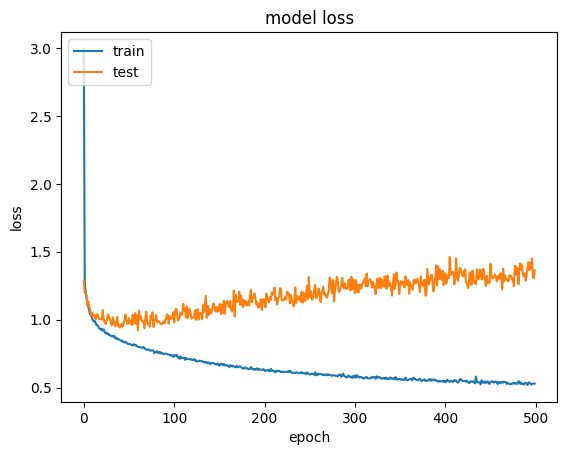

In [18]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
loss, acc = model.evaluate(X_test_cnn, y_test_e_cnn)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

22/22 [==============================] - 0s 12ms/step - loss: 1.3639 - accuracy: 0.6103
Restored model, accuracy: 61.03%


In [24]:
model_name = 'CNNSequntial_Model_8cls_131feat_61Acc.h5'
save_dir = './models'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ./models/CNNSequntial_Model_8cls_131feat_61Acc.h5 
